In [1]:
import matplotlib.pyplot as plt
import glob
import os
import sys
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.autograd import Variable
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import time

# Part 1: ALL 7 CLASS classification

## Load image

In [2]:
file_main_path = "" # Please change this path with your current setting!!!
mode = "*_merged.jpg" # Bright
G1_label = 0
G2_label = 1
S_label = 2
Anaphase_label = 3 
Metaphase_label = 4
Prophase_label = 5
Telophase_label = 6
images_number = []

In [3]:
# G1
file_sub_path = "CellCycle/G1/"
path = file_main_path + file_sub_path
G1_image = []
for filename in glob.glob(os.path.join(path, mode)):
    G1_image.append(plt.imread(filename))
G1_image = np.asarray(G1_image)
G1_index = np.full(len(G1_image), G1_label, dtype = int)
print(len(G1_image))
images_number.append(len(G1_image))

14333


In [4]:
# G2
file_sub_path = "CellCycle/G2/"
path = file_main_path + file_sub_path
G2_image = []
for filename in glob.glob(os.path.join(path, mode)):
    G2_image.append(plt.imread(filename))
G2_image = np.asarray(G2_image)
G2_index = np.full(len(G2_image), G2_label, dtype = int)
print(len(G2_image))
images_number.append(len(G2_image))

8601


In [5]:
# S
file_sub_path = "CellCycle/S/"
path = file_main_path + file_sub_path
S_image = []
for filename in glob.glob(os.path.join(path, mode)):
    S_image.append(plt.imread(filename))
S_image = np.asarray(S_image)
S_index = np.full(len(S_image), S_label, dtype = int)
print(len(S_image))
images_number.append(len(S_image))

8616


In [6]:
# Anaphase
file_sub_path = "CellCycle/Anaphase/"
path = file_main_path + file_sub_path
Anaphase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Anaphase_image.append(plt.imread(filename))
Anaphase_image = np.asarray(Anaphase_image)
Anaphase_index = np.full(len(Anaphase_image), Anaphase_label, dtype = int)
print(len(Anaphase_image))
images_number.append(len(Anaphase_image))

15


In [7]:
# Metaphase
file_sub_path = "CellCycle/Metaphase/"
path = file_main_path + file_sub_path
Metaphase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Metaphase_image.append(plt.imread(filename))
Metaphase_image = np.asarray(Metaphase_image)
Metaphase_index = np.full(len(Metaphase_image), Metaphase_label, dtype = int)
print(len(Metaphase_image))
images_number.append(len(Metaphase_image))

68


In [8]:
# Prophase
file_sub_path = "CellCycle/Prophase/"
path = file_main_path + file_sub_path
Prophase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Prophase_image.append(plt.imread(filename))
Prophase_image = np.asarray(Prophase_image)
Prophase_index = np.full(len(Prophase_image), Prophase_label, dtype = int)
print(len(Prophase_image))
images_number.append(len(Prophase_image))

606


In [9]:
# Telophase
file_sub_path = "CellCycle/Telophase/"
path = file_main_path + file_sub_path
Telophase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Telophase_image.append(plt.imread(filename))
Telophase_image = np.asarray(Telophase_image)
Telophase_index = np.full(len(Telophase_image), Telophase_label, dtype = int)
print(len(Telophase_image))
images_number.append(len(Telophase_image))

27


In [10]:
# combine all the loaded data
images = np.vstack((G1_image, G2_image, S_image, Anaphase_image, Metaphase_image, Prophase_image, Telophase_image))
index = np.concatenate((G1_index, G2_index, S_index, Anaphase_index, Metaphase_index, Prophase_index, Telophase_index))

In [11]:
#images = images[:,np.newaxis,:,:]
images = np.moveaxis(images, -1, 1)
images = images[:,:,1:65,1:65]

In [12]:
images.shape

(32266, 3, 64, 64)

In [13]:
# weight calculate
weight = np.array([round((1/i * 100),2) for i in images_number])

# NN

In [14]:
def conv3x3(in_planes, out_planes, stride, padding):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, stride = stride, padding = padding, kernel_size=3, bias=False)

def conv1x1(in_planes, out_planes, stride):
    """1x1 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, stride = stride, padding = 0, kernel_size=1, bias=False)

In [15]:
# P = ((S-1)*W-S+F)/2, with F = filter size, S = stride
class DeepFlowNet(nn.Module):
    def __init__(self, num_classes=7):
        super(DeepFlowNet, self).__init__()
        self.conv1 = conv3x3(3,96,1,1) # 3*64*64 -> 96*64*64
        self.conv1_bn = nn.BatchNorm2d(96)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2_1 = conv1x1(96, 32, 1) # 96*64*64 -> 32*64*64
        self.conv2_1_bn = nn.BatchNorm2d(32)
        self.relu2_1 = nn.ReLU(inplace=True)
        
        self.conv2_2 = conv3x3(96,32,1,1) # 96*64*64 -> 32*64*64
        self.conv2_2_bn = nn.BatchNorm2d(32)
        self.relu2_2 = nn.ReLU(inplace=True)
        
        self.conv3_1 = conv1x1(64, 32, 1) # 64*64*64 -> 32*64*64
        self.conv3_1_bn = nn.BatchNorm2d(32)
        self.relu3_1 = nn.ReLU(inplace=True)
        
        self.conv3_2 = conv3x3(64,48,1,1) # 64*64*64 -> 48*64*64
        self.conv3_2_bn = nn.BatchNorm2d(48)
        self.relu3_2 = nn.ReLU(inplace=True)
        
        self.conv4_1 = conv3x3(80,80,2,1) # 80*64*64 -> 80*64*64
        self.conv4_1_bn = nn.BatchNorm2d(80)
        self.relu4_1 = nn.ReLU(inplace=True)
        
        self.pool4_2 = nn.MaxPool2d(3,stride=2,padding=1) # 80*64*64 -> 80*32*32
        
        self.conv5_1 = conv1x1(160, 112, 1) # 160*32*32 -> 112*32*32
        self.conv5_1_bn = nn.BatchNorm2d(112)
        self.relu5_1 = nn.ReLU(inplace=True)
        
        self.conv5_2 = conv3x3(160,48,1,1) # 160*32*32 -> 48*32*32
        self.conv5_2_bn = nn.BatchNorm2d(48)
        self.relu5_2 = nn.ReLU(inplace=True)
        
        self.conv6_1 = conv1x1(160, 96, 1) # 160*32*32 -> 96*32*32
        self.conv6_1_bn = nn.BatchNorm2d(96)
        self.relu6_1 = nn.ReLU(inplace=True)
        
        self.conv6_2 = conv3x3(160,64,1,1) # 160*32*32 -> 64*32*32
        self.conv6_2_bn = nn.BatchNorm2d(64)
        self.relu6_2 = nn.ReLU(inplace=True)
        
        self.conv7_1 = conv1x1(160, 80, 1) # 160*32*32 -> 80*32*32
        self.conv7_1_bn = nn.BatchNorm2d(80)
        self.relu7_1 = nn.ReLU(inplace=True)
        
        self.conv7_2 = conv3x3(160,80,1,1) # 160*32*32 -> 80*32*32
        self.conv7_2_bn = nn.BatchNorm2d(80)
        self.relu7_2 = nn.ReLU(inplace=True)
        
        self.conv8_1 = conv1x1(160, 48, 1) # 160*32*32 -> 48*32*32
        self.conv8_1_bn = nn.BatchNorm2d(48)
        self.relu8_1 = nn.ReLU(inplace=True)
        
        self.conv8_2 = conv3x3(160,96,1,1) # 160*32*32 -> 96*32*32
        self.conv8_2_bn = nn.BatchNorm2d(96)
        self.relu8_2 = nn.ReLU(inplace=True)
        
        self.conv9_1 = conv3x3(144,96,2,1) # 144*32*32 -> 96*16*16
        self.conv9_1_bn = nn.BatchNorm2d(96)
        self.relu9_1 = nn.ReLU(inplace=True)
        
        self.pool9_2 = nn.MaxPool2d(3,stride=2,padding=1) # 144*32&32 -> 144*16*16
        
        self.conv10_1 = conv1x1(240, 176, 1) # 240*16*16 -> 176*16*16
        self.conv10_1_bn = nn.BatchNorm2d(176)
        self.relu10_1 = nn.ReLU(inplace=True)
        
        self.conv10_2 = conv3x3(240,160,1,1) # 240*16*16 -> 160*16*16
        self.conv10_2_bn = nn.BatchNorm2d(160)
        self.relu10_2 = nn.ReLU(inplace=True)
        
        self.conv11_1 = conv1x1(336, 176, 1) # 336*16*16 -> 176*16*16
        self.conv11_1_bn = nn.BatchNorm2d(176)
        self.relu11_1 = nn.ReLU(inplace=True)
        
        self.conv11_2 = conv3x3(336,160,1,1) # 336*16*16 -> 160*16*16
        self.conv11_2_bn = nn.BatchNorm2d(160)
        self.relu11_2 = nn.ReLU(inplace=True)
        
        self.conv12_1 = conv3x3(336,96,2,1) # 336*16*16 -> 96*8*8
        self.conv12_1_bn = nn.BatchNorm2d(96)
        self.relu12_1 = nn.ReLU(inplace=True)
        
        self.pool12_2 = nn.MaxPool2d(3,stride=2,padding=1) # 336*16*16 -> 336*8*8
        
        self.conv13_1 = conv1x1(432, 176, 1) # 432*8*8 -> 176*8*8
        self.conv13_1_bn = nn.BatchNorm2d(176)
        self.relu13_1 = nn.ReLU(inplace=True)
        
        self.conv13_2 = conv3x3(432,160,1,1) # 432*8*8 -> 160*8*8
        self.conv13_2_bn = nn.BatchNorm2d(160)
        self.relu13_2 = nn.ReLU(inplace=True)
        
        self.conv14_1 = conv1x1(336, 176, 1) # 336*8*8 -> 176*8*8
        self.conv14_1_bn = nn.BatchNorm2d(176)
        self.relu14_1 = nn.ReLU(inplace=True)
        
        self.conv14_2 = conv3x3(336,160,1,1) # 336*8*8 -> 160*8*8
        self.conv14_2_bn = nn.BatchNorm2d(160)
        self.relu14_2 = nn.ReLU(inplace=True)
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(336, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = self.relu1(x)
        
        x_1 = self.conv2_1(x)
        x_1 = self.conv2_1_bn(x_1)
        x_1 = self.relu2_1(x_1)
        x_2 = self.conv2_2(x)
        x_2 = self.conv2_2_bn(x_2)
        x_2 = self.relu2_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv3_1(x)
        x_1 = self.conv3_1_bn(x_1)
        x_1 = self.relu3_1(x_1)
        x_2 = self.conv3_2(x)
        x_2 = self.conv3_2_bn(x_2)
        x_2 = self.relu3_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv4_1(x)
        x_1 = self.conv4_1_bn(x_1)
        x_1 = self.relu4_1(x_1)
        x_2 = self.pool4_2(x)
        x = torch.cat([x_1, x_2], 1)

        x_1 = self.conv5_1(x)
        x_1 = self.conv5_1_bn(x_1)
        x_1 = self.relu5_1(x_1)
        x_2 = self.conv5_2(x)
        x_2 = self.conv5_2_bn(x_2)
        x_2 = self.relu5_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv6_1(x)
        x_1 = self.conv6_1_bn(x_1)
        x_1 = self.relu6_1(x_1)
        x_2 = self.conv6_2(x)
        x_2 = self.conv6_2_bn(x_2)
        x_2 = self.relu6_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv7_1(x)
        x_1 = self.conv7_1_bn(x_1)
        x_1 = self.relu7_1(x_1)
        x_2 = self.conv7_2(x)
        x_2 = self.conv7_2_bn(x_2)
        x_2 = self.relu7_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv8_1(x)
        x_1 = self.conv8_1_bn(x_1)
        x_1 = self.relu8_1(x_1)
        x_2 = self.conv8_2(x)
        x_2 = self.conv8_2_bn(x_2)
        x_2 = self.relu8_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv9_1(x)
        x_1 = self.conv9_1_bn(x_1)
        x_1 = self.relu9_1(x_1)
        x_2 = self.pool9_2(x)
        x = torch.cat([x_1, x_2], 1)

        x_1 = self.conv10_1(x)
        x_1 = self.conv10_1_bn(x_1)
        x_1 = self.relu10_1(x_1)
        x_2 = self.conv10_2(x)
        x_2 = self.conv10_2_bn(x_2)
        x_2 = self.relu10_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv11_1(x)
        x_1 = self.conv11_1_bn(x_1)
        x_1 = self.relu11_1(x_1)
        x_2 = self.conv11_2(x)
        x_2 = self.conv11_2_bn(x_2)
        x_2 = self.relu11_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv12_1(x)
        x_1 = self.conv12_1_bn(x_1)
        x_1 = self.relu12_1(x_1)
        x_2 = self.pool12_2(x)
        x = torch.cat([x_1, x_2], 1)

        x_1 = self.conv13_1(x)
        x_1 = self.conv13_1_bn(x_1)
        x_1 = self.relu13_1(x_1)
        x_2 = self.conv13_2(x)
        x_2 = self.conv13_2_bn(x_2)
        x_2 = self.relu13_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv14_1(x)
        x_1 = self.conv14_1_bn(x_1)
        x_1 = self.relu14_1(x_1)
        x_2 = self.conv14_2(x)
        x_2 = self.conv14_2_bn(x_2)
        x_2 = self.relu14_2(x_2)
        x = torch.cat([x_1, x_2], 1)

        tsne = self.avgpool(x)
        x = tsne.view(tsne.size(0), -1)

        x = self.fc(x)
        x = self.softmax(x)
        
        return tsne, x

In [16]:
EPOCH = 200
BATCH_SIZE = 10
LR = 0.001
deepflownet = DeepFlowNet().cuda(1)
print(deepflownet)
optimizer = torch.optim.Adam(deepflownet.parameters(), lr=LR)   # optimize all cnn parameters
# loss function setting
# class_weights = torch.FloatTensor(weight).cuda(1)
loss_func = nn.CrossEntropyLoss()
#loss_func = nn.CrossEntropyLoss(weight = class_weights)

DeepFlowNet(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2_1): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2_1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (conv3_1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv3_1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3_2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, af

In [17]:
idx = np.random.permutation(len(images))
x, y = images[idx], index[idx]

In [18]:
# Split data to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = np.expand_dims(y_train,axis = 1)
y_test = np.expand_dims(y_test,axis = 1)

# Change dtype to tensor and float format
X_train_torch = torch.from_numpy(X_train)
X_test_torch = torch.from_numpy(X_test)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

X_train_torch = X_train_torch.float()
y_train_torch = y_train_torch.long()
X_test_torch = X_test_torch.float()
y_test_torch = y_test_torch.long()

In [19]:
# start training
start_time = time.time()
loss_list = []
for epoch in range(EPOCH):
    step_length = len(range(0, X_train_torch.size(0), BATCH_SIZE))
    print("epoch: ", str(epoch+1))
    
    losses = []
    for step, beg_i in enumerate(range(0, X_train_torch.size(0), BATCH_SIZE)):
        
        processing = str(round(((step)/ step_length * 100),2)) + "% " +"\r"
        sys.stdout.write(processing)
        sys.stdout.flush()
        
        x_batch = X_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda(1)
        y_batch = y_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda(1)
        #y_temp = y_batch.cpu().numpy()
        #y_temp_label = np.where(y_temp == 1)[1]
        #print(y_temp_label)
        #y_batch = torch.from_numpy(y_temp_label).long().cuda()
        
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        tsne, output = deepflownet(x_batch)              # cnn output
        loss = loss_func(output, y_batch.squeeze())   # cross entropy loss
        losses.append(float(loss.cpu().data.numpy()))
        #losses.append(float(loss.cpu().data.numpy()))
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    loss_list.append(sum(losses))
end_time = time.time()
print(end_time-start_time)

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  91
epoch:  

In [24]:
deepflownet.cpu()
#class_weights = torch.FloatTensor(weight).cpu()
torch.save(deepflownet.state_dict(), "DeepFlowNet_7class_ver8.pkl")

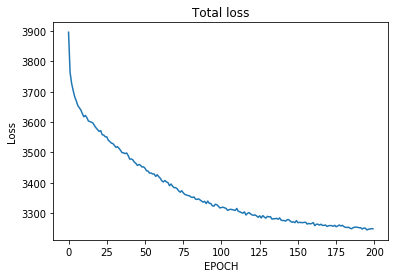

In [25]:
# Loss changing during training
plt.plot(range(0,EPOCH), loss_list)
plt.xlabel("EPOCH")
plt.ylabel("Loss")
plt.title("Total loss")
plt.show()

In [26]:
# predict by part
start_time = time.time()
part = 200
accuracy_sum = 0 
prediction_list = []
tsne_list = []
for i in range(part):
    print("finish ", (i+1), " / ", part)
    start = int(i / part * len(X_test_torch))
    end = int((i+1) / part * len(X_test_torch))
    X_test_torch_part = X_test_torch[start:end]
    y_test_torch_part = y_test_torch[start:end]
    with torch.no_grad():
        tsne, test_output = deepflownet(X_test_torch_part)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        prediction_list.append(pred_y.numpy())
        tsne_list.append(tsne.numpy())
        accuracy = sum(pred_y == y_test_torch_part.squeeze()).item()
        accuracy_sum += accuracy
print("accuracy: ", accuracy_sum/len(X_test_torch))
end_time = time.time()
print(end_time-start_time)

finish  1  /  200
finish  2  /  200
finish  3  /  200
finish  4  /  200
finish  5  /  200
finish  6  /  200
finish  7  /  200
finish  8  /  200
finish  9  /  200
finish  10  /  200
finish  11  /  200
finish  12  /  200
finish  13  /  200
finish  14  /  200
finish  15  /  200
finish  16  /  200
finish  17  /  200
finish  18  /  200
finish  19  /  200
finish  20  /  200
finish  21  /  200
finish  22  /  200
finish  23  /  200
finish  24  /  200
finish  25  /  200
finish  26  /  200
finish  27  /  200
finish  28  /  200
finish  29  /  200
finish  30  /  200
finish  31  /  200
finish  32  /  200
finish  33  /  200
finish  34  /  200
finish  35  /  200
finish  36  /  200
finish  37  /  200
finish  38  /  200
finish  39  /  200
finish  40  /  200
finish  41  /  200
finish  42  /  200
finish  43  /  200
finish  44  /  200
finish  45  /  200
finish  46  /  200
finish  47  /  200
finish  48  /  200
finish  49  /  200
finish  50  /  200
finish  51  /  200
finish  52  /  200
finish  53  /  200
fi

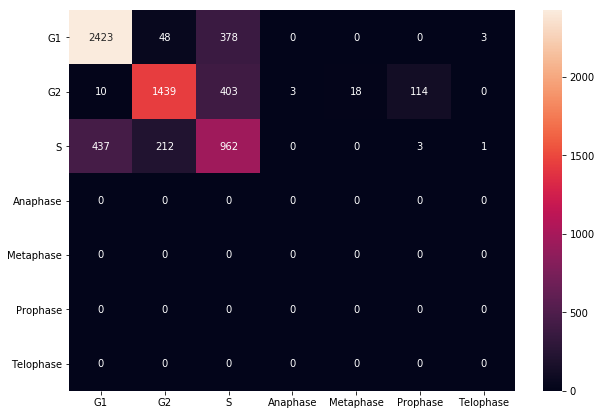

In [27]:
#confusion table
prediction_list_numpy = np.array([num for elem in prediction_list for num in elem])
y_test_numpy = np.asarray(y_test_torch).flatten()
confusion = confusion_matrix(prediction_list_numpy, y_test_numpy)

label_list = ["G1", "G2", "S", "Anaphase","Metaphase", "Prophase","Telophase"]
# Confusion table without normalization
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
#plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()

In [27]:
tsne_list_numpy = tsne_list[0]
for i in tsne_list[1:]:
    tsne_list_numpy = np.concatenate((tsne_list_numpy,i),axis = 0)

In [28]:
tsne_list_numpy = tsne_list_numpy.reshape(tsne_list_numpy.shape[0],tsne_list_numpy.shape[1])
tsne_list_numpy.shape

(6454, 336)

In [29]:
# TSNE 
tsne_list_embedded = TSNE(n_components=3, init="pca").fit_transform(tsne_list_numpy)
tsne_list_embedded.shape

(6454, 3)

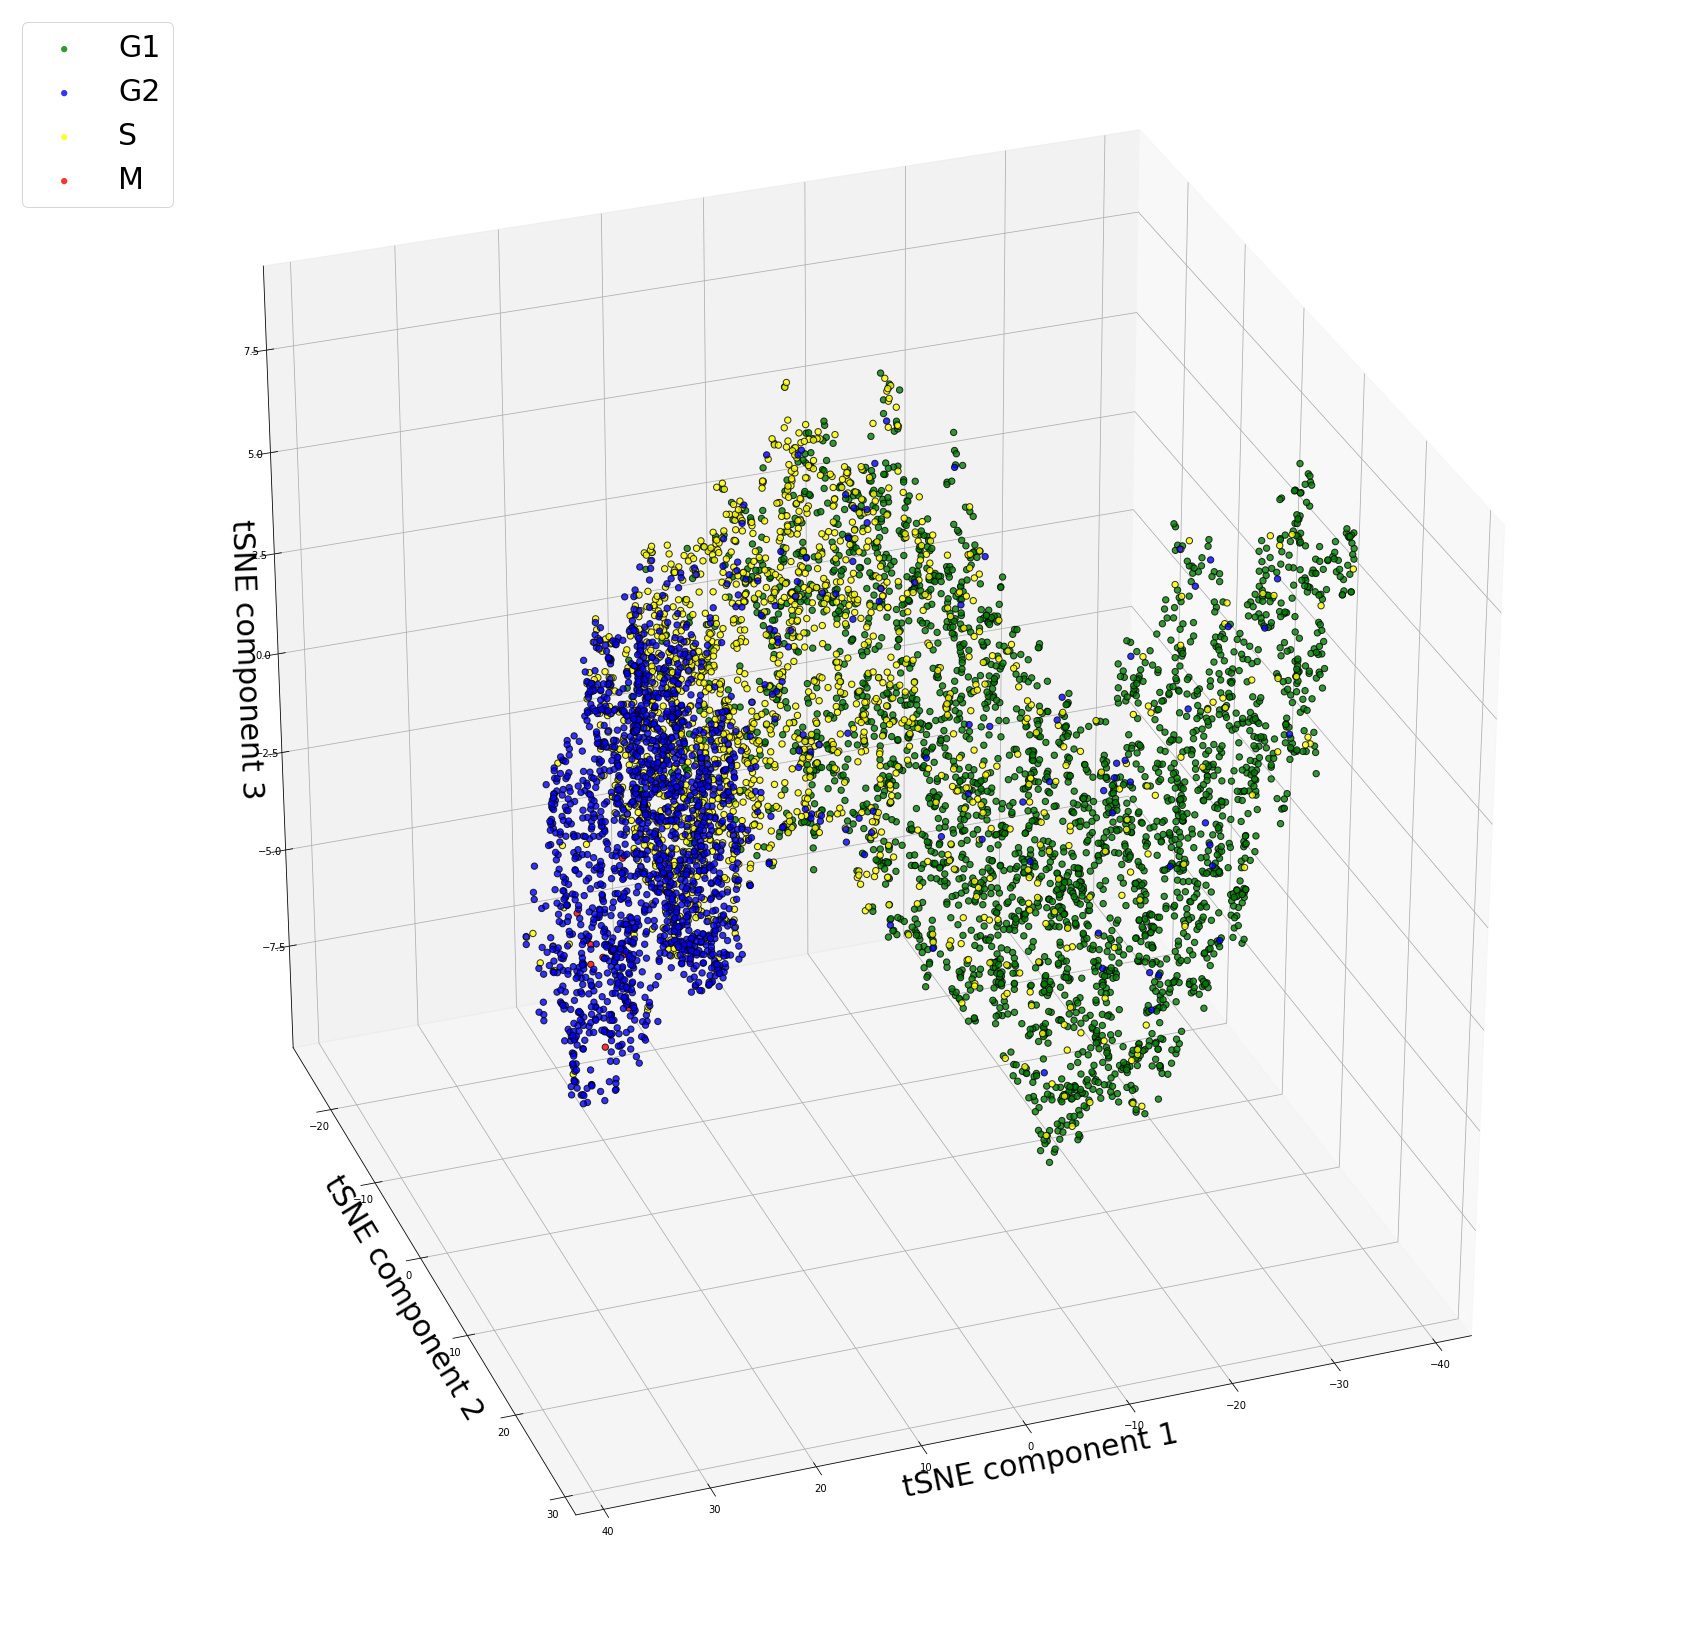

In [30]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(tsne_list_embedded_select[:,0], tsne_list_embedded_select[:,1], tsne_list_embedded_select[:,2], c=tsne_list_embedded_label, marker="o")
ax.scatter(tsne_list_embedded[y_test_numpy == 0][:,0], tsne_list_embedded[y_test_numpy == 0][:,1], tsne_list_embedded[y_test_numpy == 0][:,2], alpha=0.8, c="green", edgecolors='none', s=40, label="G1")
ax.scatter(tsne_list_embedded[y_test_numpy == 1][:,0], tsne_list_embedded[y_test_numpy == 1][:,1], tsne_list_embedded[y_test_numpy == 1][:,2], alpha=0.8, c="blue", edgecolors='none', s=40, label="G2")
ax.scatter(tsne_list_embedded[y_test_numpy == 2][:,0], tsne_list_embedded[y_test_numpy == 2][:,1], tsne_list_embedded[y_test_numpy == 2][:,2], alpha=0.8, c="yellow", edgecolors='none', s=40, label="S")
ax.scatter(tsne_list_embedded[y_test_numpy == 4][:,0], tsne_list_embedded[y_test_numpy == 4][:,1], tsne_list_embedded[y_test_numpy == 4][:,2], alpha=0.8, c="red", edgecolors='none', s=40, label="M")
ax.set_xlabel('tSNE component 1', size = 30)
ax.set_ylabel('tSNE component 2', size = 30)
ax.set_zlabel('tSNE component 3', size = 30)
ax.view_init(30, 70)
plt.legend(loc=2, prop={'size': 30})
plt.show()

# Part 2: 5 CLASS classification

In [2]:
file_main_path = "" # Please change this path with your current setting!!!
mode = "*_merged.jpg" # Bright
G1_label = 0
G2_label = 0
S_label = 0
Anaphase_label = 1
Metaphase_label = 2
Prophase_label = 3
Telophase_label = 4
images_number = []

In [3]:
# G1
file_sub_path = "CellCycle/G1/"
path = file_main_path + file_sub_path
G1_image = []
for filename in glob.glob(os.path.join(path, mode)):
    G1_image.append(plt.imread(filename))
G1_image = np.asarray(G1_image)
G1_index = np.full(len(G1_image), G1_label, dtype = int)
print(len(G1_image))
images_number.append(len(G1_image))

14333


In [4]:
# G2
file_sub_path = "CellCycle/G2/"
path = file_main_path + file_sub_path
G2_image = []
for filename in glob.glob(os.path.join(path, mode)):
    G2_image.append(plt.imread(filename))
G2_image = np.asarray(G2_image)
G2_index = np.full(len(G2_image), G2_label, dtype = int)
print(len(G2_image))
images_number.append(len(G2_image))

8601


In [5]:
# S
file_sub_path = "CellCycle/S/"
path = file_main_path + file_sub_path
S_image = []
for filename in glob.glob(os.path.join(path, mode)):
    S_image.append(plt.imread(filename))
S_image = np.asarray(S_image)
S_index = np.full(len(S_image), S_label, dtype = int)
print(len(S_image))
images_number.append(len(S_image))

8616


In [6]:
# Anaphase
file_sub_path = "CellCycle/Anaphase/"
path = file_main_path + file_sub_path
Anaphase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Anaphase_image.append(plt.imread(filename))
Anaphase_image = np.asarray(Anaphase_image)
Anaphase_index = np.full(len(Anaphase_image), Anaphase_label, dtype = int)
print(len(Anaphase_image))
images_number.append(len(Anaphase_image))

15


In [7]:
# Metaphase
file_sub_path = "CellCycle/Metaphase/"
path = file_main_path + file_sub_path
Metaphase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Metaphase_image.append(plt.imread(filename))
Metaphase_image = np.asarray(Metaphase_image)
Metaphase_index = np.full(len(Metaphase_image), Metaphase_label, dtype = int)
print(len(Metaphase_image))
images_number.append(len(Metaphase_image))

68


In [8]:
# Prophase
file_sub_path = "CellCycle/Prophase/"
path = file_main_path + file_sub_path
Prophase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Prophase_image.append(plt.imread(filename))
Prophase_image = np.asarray(Prophase_image)
Prophase_index = np.full(len(Prophase_image), Prophase_label, dtype = int)
print(len(Prophase_image))
images_number.append(len(Prophase_image))

606


In [9]:
# Telophase
file_sub_path = "CellCycle/Telophase/"
path = file_main_path + file_sub_path
Telophase_image = []
for filename in glob.glob(os.path.join(path, mode)):
    Telophase_image.append(plt.imread(filename))
Telophase_image = np.asarray(Telophase_image)
Telophase_index = np.full(len(Telophase_image), Telophase_label, dtype = int)
print(len(Telophase_image))
images_number.append(len(Telophase_image))

27


In [10]:
# combine all the loaded data
images = np.vstack((G1_image, G2_image, S_image, Anaphase_image, Metaphase_image, Prophase_image, Telophase_image))
index = np.concatenate((G1_index, G2_index, S_index, Anaphase_index, Metaphase_index, Prophase_index, Telophase_index))

In [11]:
#images = images[:,np.newaxis,:,:]
images = np.moveaxis(images, -1, 1)
images = images[:,:,1:65,1:65]

In [12]:
images.shape

(32266, 3, 64, 64)

In [13]:
images_number = [(images_number[0] + images_number[1] + images_number[2]), images_number[3], images_number[4], images_number[5],images_number[6]]
images_number

[31550, 15, 68, 606, 27]

In [14]:
# weight calculate
weight = np.array([round((1/i*100),5) for i in images_number])

In [15]:
weight

array([3.17000e-03, 6.66667e+00, 1.47059e+00, 1.65020e-01, 3.70370e+00])

In [16]:
def conv3x3(in_planes, out_planes, stride, padding):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, stride = stride, padding = padding, kernel_size=3, bias=False)

def conv1x1(in_planes, out_planes, stride):
    """1x1 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, stride = stride, padding = 0, kernel_size=1, bias=False)
# P = ((S-1)*W-S+F)/2, with F = filter size, S = stride
class DeepFlowNet(nn.Module):
    def __init__(self, num_classes=5):
        super(DeepFlowNet, self).__init__()
        self.conv1 = conv3x3(3,96,1,1) # 3*64*64 -> 96*64*64
        self.conv1_bn = nn.BatchNorm2d(96)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.conv2_1 = conv1x1(96, 32, 1) # 96*64*64 -> 32*64*64
        self.conv2_1_bn = nn.BatchNorm2d(32)
        self.relu2_1 = nn.ReLU(inplace=True)
        
        self.conv2_2 = conv3x3(96,32,1,1) # 96*64*64 -> 32*64*64
        self.conv2_2_bn = nn.BatchNorm2d(32)
        self.relu2_2 = nn.ReLU(inplace=True)
        
        self.conv3_1 = conv1x1(64, 32, 1) # 64*64*64 -> 32*64*64
        self.conv3_1_bn = nn.BatchNorm2d(32)
        self.relu3_1 = nn.ReLU(inplace=True)
        
        self.conv3_2 = conv3x3(64,48,1,1) # 64*64*64 -> 48*64*64
        self.conv3_2_bn = nn.BatchNorm2d(48)
        self.relu3_2 = nn.ReLU(inplace=True)
        
        self.conv4_1 = conv3x3(80,80,2,1) # 80*64*64 -> 80*64*64
        self.conv4_1_bn = nn.BatchNorm2d(80)
        self.relu4_1 = nn.ReLU(inplace=True)
        
        self.pool4_2 = nn.MaxPool2d(3,stride=2,padding=1) # 80*64*64 -> 80*32*32
        
        self.conv5_1 = conv1x1(160, 112, 1) # 160*32*32 -> 112*32*32
        self.conv5_1_bn = nn.BatchNorm2d(112)
        self.relu5_1 = nn.ReLU(inplace=True)
        
        self.conv5_2 = conv3x3(160,48,1,1) # 160*32*32 -> 48*32*32
        self.conv5_2_bn = nn.BatchNorm2d(48)
        self.relu5_2 = nn.ReLU(inplace=True)
        
        self.conv6_1 = conv1x1(160, 96, 1) # 160*32*32 -> 96*32*32
        self.conv6_1_bn = nn.BatchNorm2d(96)
        self.relu6_1 = nn.ReLU(inplace=True)
        
        self.conv6_2 = conv3x3(160,64,1,1) # 160*32*32 -> 64*32*32
        self.conv6_2_bn = nn.BatchNorm2d(64)
        self.relu6_2 = nn.ReLU(inplace=True)
        
        self.conv7_1 = conv1x1(160, 80, 1) # 160*32*32 -> 80*32*32
        self.conv7_1_bn = nn.BatchNorm2d(80)
        self.relu7_1 = nn.ReLU(inplace=True)
        
        self.conv7_2 = conv3x3(160,80,1,1) # 160*32*32 -> 80*32*32
        self.conv7_2_bn = nn.BatchNorm2d(80)
        self.relu7_2 = nn.ReLU(inplace=True)
        
        self.conv8_1 = conv1x1(160, 48, 1) # 160*32*32 -> 48*32*32
        self.conv8_1_bn = nn.BatchNorm2d(48)
        self.relu8_1 = nn.ReLU(inplace=True)
        
        self.conv8_2 = conv3x3(160,96,1,1) # 160*32*32 -> 96*32*32
        self.conv8_2_bn = nn.BatchNorm2d(96)
        self.relu8_2 = nn.ReLU(inplace=True)
        
        self.conv9_1 = conv3x3(144,96,2,1) # 144*32*32 -> 96*16*16
        self.conv9_1_bn = nn.BatchNorm2d(96)
        self.relu9_1 = nn.ReLU(inplace=True)
        
        self.pool9_2 = nn.MaxPool2d(3,stride=2,padding=1) # 144*32&32 -> 144*16*16
        
        self.conv10_1 = conv1x1(240, 176, 1) # 240*16*16 -> 176*16*16
        self.conv10_1_bn = nn.BatchNorm2d(176)
        self.relu10_1 = nn.ReLU(inplace=True)
        
        self.conv10_2 = conv3x3(240,160,1,1) # 240*16*16 -> 160*16*16
        self.conv10_2_bn = nn.BatchNorm2d(160)
        self.relu10_2 = nn.ReLU(inplace=True)
        
        self.conv11_1 = conv1x1(336, 176, 1) # 336*16*16 -> 176*16*16
        self.conv11_1_bn = nn.BatchNorm2d(176)
        self.relu11_1 = nn.ReLU(inplace=True)
        
        self.conv11_2 = conv3x3(336,160,1,1) # 336*16*16 -> 160*16*16
        self.conv11_2_bn = nn.BatchNorm2d(160)
        self.relu11_2 = nn.ReLU(inplace=True)
        
        self.conv12_1 = conv3x3(336,96,2,1) # 336*16*16 -> 96*8*8
        self.conv12_1_bn = nn.BatchNorm2d(96)
        self.relu12_1 = nn.ReLU(inplace=True)
        
        self.pool12_2 = nn.MaxPool2d(3,stride=2,padding=1) # 336*16*16 -> 336*8*8
        
        self.conv13_1 = conv1x1(432, 176, 1) # 432*8*8 -> 176*8*8
        self.conv13_1_bn = nn.BatchNorm2d(176)
        self.relu13_1 = nn.ReLU(inplace=True)
        
        self.conv13_2 = conv3x3(432,160,1,1) # 432*8*8 -> 160*8*8
        self.conv13_2_bn = nn.BatchNorm2d(160)
        self.relu13_2 = nn.ReLU(inplace=True)
        
        self.conv14_1 = conv1x1(336, 176, 1) # 336*8*8 -> 176*8*8
        self.conv14_1_bn = nn.BatchNorm2d(176)
        self.relu14_1 = nn.ReLU(inplace=True)
        
        self.conv14_2 = conv3x3(336,160,1,1) # 336*8*8 -> 160*8*8
        self.conv14_2_bn = nn.BatchNorm2d(160)
        self.relu14_2 = nn.ReLU(inplace=True)
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(336, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = self.relu1(x)
        
        x_1 = self.conv2_1(x)
        x_1 = self.conv2_1_bn(x_1)
        x_1 = self.relu2_1(x_1)
        x_2 = self.conv2_2(x)
        x_2 = self.conv2_2_bn(x_2)
        x_2 = self.relu2_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv3_1(x)
        x_1 = self.conv3_1_bn(x_1)
        x_1 = self.relu3_1(x_1)
        x_2 = self.conv3_2(x)
        x_2 = self.conv3_2_bn(x_2)
        x_2 = self.relu3_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv4_1(x)
        x_1 = self.conv4_1_bn(x_1)
        x_1 = self.relu4_1(x_1)
        x_2 = self.pool4_2(x)
        x = torch.cat([x_1, x_2], 1)

        x_1 = self.conv5_1(x)
        x_1 = self.conv5_1_bn(x_1)
        x_1 = self.relu5_1(x_1)
        x_2 = self.conv5_2(x)
        x_2 = self.conv5_2_bn(x_2)
        x_2 = self.relu5_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv6_1(x)
        x_1 = self.conv6_1_bn(x_1)
        x_1 = self.relu6_1(x_1)
        x_2 = self.conv6_2(x)
        x_2 = self.conv6_2_bn(x_2)
        x_2 = self.relu6_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv7_1(x)
        x_1 = self.conv7_1_bn(x_1)
        x_1 = self.relu7_1(x_1)
        x_2 = self.conv7_2(x)
        x_2 = self.conv7_2_bn(x_2)
        x_2 = self.relu7_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv8_1(x)
        x_1 = self.conv8_1_bn(x_1)
        x_1 = self.relu8_1(x_1)
        x_2 = self.conv8_2(x)
        x_2 = self.conv8_2_bn(x_2)
        x_2 = self.relu8_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv9_1(x)
        x_1 = self.conv9_1_bn(x_1)
        x_1 = self.relu9_1(x_1)
        x_2 = self.pool9_2(x)
        x = torch.cat([x_1, x_2], 1)

        x_1 = self.conv10_1(x)
        x_1 = self.conv10_1_bn(x_1)
        x_1 = self.relu10_1(x_1)
        x_2 = self.conv10_2(x)
        x_2 = self.conv10_2_bn(x_2)
        x_2 = self.relu10_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv11_1(x)
        x_1 = self.conv11_1_bn(x_1)
        x_1 = self.relu11_1(x_1)
        x_2 = self.conv11_2(x)
        x_2 = self.conv11_2_bn(x_2)
        x_2 = self.relu11_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv12_1(x)
        x_1 = self.conv12_1_bn(x_1)
        x_1 = self.relu12_1(x_1)
        x_2 = self.pool12_2(x)
        x = torch.cat([x_1, x_2], 1)

        x_1 = self.conv13_1(x)
        x_1 = self.conv13_1_bn(x_1)
        x_1 = self.relu13_1(x_1)
        x_2 = self.conv13_2(x)
        x_2 = self.conv13_2_bn(x_2)
        x_2 = self.relu13_2(x_2)
        x = torch.cat([x_1, x_2], 1)
        
        x_1 = self.conv14_1(x)
        x_1 = self.conv14_1_bn(x_1)
        x_1 = self.relu14_1(x_1)
        x_2 = self.conv14_2(x)
        x_2 = self.conv14_2_bn(x_2)
        x_2 = self.relu14_2(x_2)
        x = torch.cat([x_1, x_2], 1)

        tsne = self.avgpool(x)
        x = tsne.view(tsne.size(0), -1)

        x = self.fc(x)
        x = self.softmax(x)
        
        return tsne, x

In [17]:
EPOCH = 150
BATCH_SIZE = 20
LR = 0.001
deepflownet = DeepFlowNet().cuda(1)
print(deepflownet)
optimizer = torch.optim.Adam(deepflownet.parameters(), lr=LR)   # optimize all cnn parameters
# loss function setting
class_weights = torch.FloatTensor(weight).cuda(1)
loss_func = nn.CrossEntropyLoss(weight = class_weights)
#loss_func = nn.CrossEntropyLoss()

DeepFlowNet(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2_1): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv2_1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2_2): ReLU(inplace=True)
  (conv3_1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (conv3_1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3_2_bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, af

In [18]:
idx = np.random.permutation(len(images))
x, y = images[idx], index[idx]

In [19]:
# Split data to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = np.expand_dims(y_train,axis = 1)
y_test = np.expand_dims(y_test,axis = 1)

# Change dtype to tensor and float format
X_train_torch = torch.from_numpy(X_train)
X_test_torch = torch.from_numpy(X_test)
y_train_torch = torch.from_numpy(y_train)
y_test_torch = torch.from_numpy(y_test)

X_train_torch = X_train_torch.float()
y_train_torch = y_train_torch.long()
X_test_torch = X_test_torch.float()
y_test_torch = y_test_torch.long()

In [20]:
# start training
start_time = time.time()
loss_list = []
for epoch in range(EPOCH):
    step_length = len(range(0, X_train_torch.size(0), BATCH_SIZE))
    print("epoch: ", str(epoch+1))
    
    losses = []
    for step, beg_i in enumerate(range(0, X_train_torch.size(0), BATCH_SIZE)):
        
        processing = str(round(((step)/ step_length * 100),2)) + "% " +"\r"
        sys.stdout.write(processing)
        sys.stdout.flush()
        
        x_batch = X_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda(1)
        y_batch = y_train_torch[beg_i:beg_i + BATCH_SIZE, :].cuda(1)
        #y_temp = y_batch.cpu().numpy()
        #y_temp_label = np.where(y_temp == 1)[1]
        #print(y_temp_label)
        #y_batch = torch.from_numpy(y_temp_label).long().cuda()
        
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        tsne, output = deepflownet(x_batch)              # cnn output
        loss = loss_func(output, y_batch.squeeze())   # cross entropy loss
        losses.append(float(loss.cpu().data.numpy()))
        #losses.append(float(loss.cpu().data.numpy()))
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    loss_list.append(sum(losses))
end_time = time.time()
print(end_time-start_time)

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  91
epoch:  

In [21]:
deepflownet.cpu()
torch.save(deepflownet.state_dict(), "DeepFlowNet_5class_ver4.pkl")

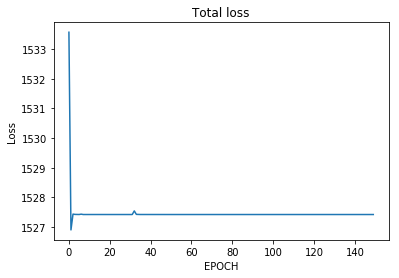

In [22]:
# Loss changing during training
plt.plot(range(0,EPOCH), loss_list)
plt.xlabel("EPOCH")
plt.ylabel("Loss")
plt.title("Total loss")
plt.show()

In [23]:
# predict by part
start_time = time.time()
part = 200
accuracy_sum = 0 
prediction_list = []
tsne_list = []
for i in range(part):
    print("finish ", (i+1), " / ", part)
    start = int(i / part * len(X_test_torch))
    end = int((i+1) / part * len(X_test_torch))
    X_test_torch_part = X_test_torch[start:end]
    y_test_torch_part = y_test_torch[start:end]
    with torch.no_grad():
        tsne, test_output = deepflownet(X_test_torch_part)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        prediction_list.append(pred_y.numpy())
        tsne_list.append(tsne.numpy())
        accuracy = sum(pred_y == y_test_torch_part.squeeze()).item()
        accuracy_sum += accuracy
print("accuracy: ", accuracy_sum/len(X_test_torch))
end_time = time.time()
print(end_time-start_time)

finish  1  /  200
finish  2  /  200
finish  3  /  200
finish  4  /  200
finish  5  /  200
finish  6  /  200
finish  7  /  200
finish  8  /  200
finish  9  /  200
finish  10  /  200
finish  11  /  200
finish  12  /  200
finish  13  /  200
finish  14  /  200
finish  15  /  200
finish  16  /  200
finish  17  /  200
finish  18  /  200
finish  19  /  200
finish  20  /  200
finish  21  /  200
finish  22  /  200
finish  23  /  200
finish  24  /  200
finish  25  /  200
finish  26  /  200
finish  27  /  200
finish  28  /  200
finish  29  /  200
finish  30  /  200
finish  31  /  200
finish  32  /  200
finish  33  /  200
finish  34  /  200
finish  35  /  200
finish  36  /  200
finish  37  /  200
finish  38  /  200
finish  39  /  200
finish  40  /  200
finish  41  /  200
finish  42  /  200
finish  43  /  200
finish  44  /  200
finish  45  /  200
finish  46  /  200
finish  47  /  200
finish  48  /  200
finish  49  /  200
finish  50  /  200
finish  51  /  200
finish  52  /  200
finish  53  /  200
fi

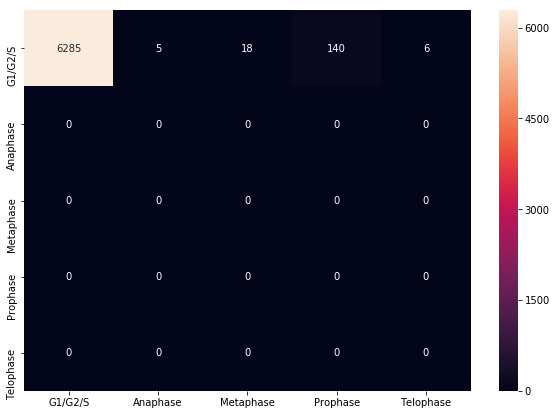

In [24]:
#confusion table
prediction_list_numpy = np.array([num for elem in prediction_list for num in elem])
y_test_numpy = np.asarray(y_test_torch).flatten()
confusion = confusion_matrix(prediction_list_numpy, y_test_numpy)

label_list = ["G1/G2/S", "Anaphase","Metaphase", "Prophase","Telophase"]
# Confusion table without normalization
df_cm = pd.DataFrame(confusion, index = [i for i in label_list],
                  columns = [i for i in label_list])
plt.figure(figsize = (10,7))
#plt.title("4-fold Crossvalidation(CV"+str(CV+1)+"): Confusion matrix", size = 15)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g')
plt.show()